<a href="https://colab.research.google.com/github/RajeswariKumaran/SSLMethodsAnalysis/blob/main/MeanTeacher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
import copy

# Your model architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(8*8*128, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Mean Teacher training routine
def train_mean_teacher(
    student_model,
    teacher_model,
    labelled_loader,
    unlabelled_loader,
    optimizer,
    criterion_supervised,
    consistency_criterion,  # e.g. MSE between student & teacher outputs
    device,
    epochs=100,
    lambda_consistency=1.0,
    ema_decay=0.99
):
    student_model.to(device)
    teacher_model.to(device)
    teacher_model.eval()

    for epoch in range(epochs):
        student_model.train()

        # iterate over both labelled + unlabelled data
        # we assume labelled_loader and unlabelled_loader are infinite or we cycle through shorter one
        len_loader = max(len(labelled_loader), len(unlabelled_loader))
        unl_iter = iter(unlabelled_loader)
        lab_iter = iter(labelled_loader)

        for batch_idx in range(len_loader):
            try:
                lab_inputs, lab_targets = next(lab_iter)
            except StopIteration:
                lab_iter = iter(labelled_loader)
                lab_inputs, lab_targets = next(lab_iter)

            try:
                unlab_inputs, _ = next(unl_iter)
            except StopIteration:
                unl_iter = iter(unlabelled_loader)
                unlab_inputs, _ = next(unl_iter)

            # Move to device
            lab_inputs, lab_targets = lab_inputs.to(device), lab_targets.to(device)
            unlab_inputs = unlab_inputs.to(device)

            # Augment / add noise etc if needed
            # Here, for example, two different augmentations for consistency
            # For simplicity we use the same inputs for student & teacher but you can apply different augmentations
            # For example:
            #   student_unlab_outputs = student_model(augment(unlab_inputs))
            #   teacher_unlab_outputs = teacher_model(augment_different(unlab_inputs))
            student_unlab_outputs = student_model(unlab_inputs)
            with torch.no_grad():
                teacher_unlab_outputs = teacher_model(unlab_inputs)

            # Supervised loss
            lab_outputs = student_model(lab_inputs)
            loss_supervised = criterion_supervised(lab_outputs, lab_targets)

            # Consistency loss
            # For example, MSE between softmax outputs
            # Or KL divergence, etc.
            # Here we’ll use Mean Squared Error on softmax probabilities:
            loss_consistency = consistency_criterion(
                F.softmax(student_unlab_outputs, dim=1),
                F.softmax(teacher_unlab_outputs, dim=1)
            )

            loss = loss_supervised + lambda_consistency * loss_consistency

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update teacher weights via EMA of student weights
            # teacher = ema_decay * teacher + (1 - ema_decay) * student
            with torch.no_grad():
                for tp, sp in zip(teacher_model.parameters(), student_model.parameters()):
                    tp.data.mul_(ema_decay).add_(sp.data * (1 - ema_decay))

        print(f"Epoch {epoch+1}/{epochs} — Supervised Loss: {loss_supervised.item():.4f}, Consistency Loss: {loss_consistency.item():.4f}")

    return student_model, teacher_model



In [ ]:
def get_cifar_datasets():
  import numpy as np
  import torch
  from torchvision import datasets, transforms
  from torch.utils.data import DataLoader, Subset
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # Data transforms
  transform_train = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomCrop(32, padding=4),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465),
                            (0.247, 0.243, 0.261))
  ])
  transform_test = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465),
                            (0.247, 0.243, 0.261))
  ])

  # Download CIFAR-10 dataset
  full_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
  test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

  # Create labelled / unlabelled splits
  num_labelled = 4000  # e.g. 4000 labelled, rest unlabelled

    # Randomly split labeled/unlabeled
  indices = np.arange(len(full_train))
  np.random.shuffle(indices)
  labeled_indices = indices[:num_labelled]
  unlabeled_indices = indices[num_labelled:]
  # torch.random.shuffle(torch.Tensor(indices))

  labelled_indices = indices[:num_labelled]
  unlabelled_indices = indices[num_labelled:]

  labelled_set = Subset(full_train, labelled_indices)
  unlabelled_set = Subset(full_train, unlabelled_indices)

  labelled_loader = DataLoader(labelled_set, batch_size=64, shuffle=True, num_workers=2, drop_last=True)
  unlabelled_loader = DataLoader(unlabelled_set, batch_size=64, shuffle=True, num_workers=2, drop_last=True)
  test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=2)

  return labelled_loader, unlabelled_loader, test_loader

In [ ]:
labelled_loader, unlabelled_loader, test_loader = get_cifar_datasets()

In [ ]:
print(len(labelled_loader.dataset))
print(len(unlabelled_loader.dataset))
print(len(test_loader.dataset))

4000
46000
10000


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

def evaluate(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    # Flatten predictions and labels
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_labels).numpy()

    # Compute accuracy
    accuracy = np.mean(y_pred == y_true)
    print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")

    # Classification report
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=[
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[
                    'airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'
                ],
                yticklabels=[
                    'airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'
                ])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize student + teacher
student = SimpleCNN(num_classes=10)
teacher = copy.deepcopy(student)

# Losses and optimizer
criterion_supervised = nn.CrossEntropyLoss()
consistency_criterion = nn.MSELoss()

optimizer = optim.Adam(student.parameters(), lr=1e-3)

# Hyperparameters
lambda_consistency = 1.0
ema_decay = 0.99
epochs = 30

# Train
student, teacher = train_mean_teacher(
    student_model=student,
    teacher_model=teacher,
    labelled_loader=labelled_loader,
    unlabelled_loader=unlabelled_loader,
    optimizer=optimizer,
    criterion_supervised=criterion_supervised,
    consistency_criterion=consistency_criterion,
    device=device,
    epochs=epochs,
    lambda_consistency=lambda_consistency,
    ema_decay=ema_decay
)

# Test student
student.eval()
total = 0
correct = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = student(inputs)
        _, preds = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (preds == targets).sum().item()

print(f"Test Accuracy: {correct/total:.4f}")


Epoch 1/30 — Supervised Loss: 1.2168, Consistency Loss: 0.0033
Epoch 2/30 — Supervised Loss: 0.9963, Consistency Loss: 0.0032
Epoch 3/30 — Supervised Loss: 0.9233, Consistency Loss: 0.0034
Epoch 4/30 — Supervised Loss: 0.8115, Consistency Loss: 0.0034
Epoch 5/30 — Supervised Loss: 0.5757, Consistency Loss: 0.0027
Epoch 6/30 — Supervised Loss: 0.7406, Consistency Loss: 0.0036
Epoch 7/30 — Supervised Loss: 0.5215, Consistency Loss: 0.0037
Epoch 8/30 — Supervised Loss: 0.5747, Consistency Loss: 0.0044
Epoch 9/30 — Supervised Loss: 0.5849, Consistency Loss: 0.0035
Epoch 10/30 — Supervised Loss: 0.3381, Consistency Loss: 0.0050
Epoch 11/30 — Supervised Loss: 0.4998, Consistency Loss: 0.0055
Epoch 12/30 — Supervised Loss: 0.5525, Consistency Loss: 0.0044
Epoch 13/30 — Supervised Loss: 0.3012, Consistency Loss: 0.0082
Epoch 14/30 — Supervised Loss: 0.3265, Consistency Loss: 0.0034
Epoch 15/30 — Supervised Loss: 0.4821, Consistency Loss: 0.0079
Epoch 16/30 — Supervised Loss: 0.2246, Consistenc


✅ Test Accuracy: 60.08%

📊 Classification Report:
              precision    recall  f1-score   support

    airplane       0.62      0.63      0.62      1000
  automobile       0.68      0.75      0.71      1000
        bird       0.54      0.50      0.52      1000
         cat       0.37      0.44      0.40      1000
        deer       0.59      0.44      0.50      1000
         dog       0.47      0.55      0.51      1000
        frog       0.67      0.73      0.70      1000
       horse       0.66      0.63      0.64      1000
        ship       0.77      0.70      0.74      1000
       truck       0.71      0.64      0.67      1000

    accuracy                           0.60     10000
   macro avg       0.61      0.60      0.60     10000
weighted avg       0.61      0.60      0.60     10000



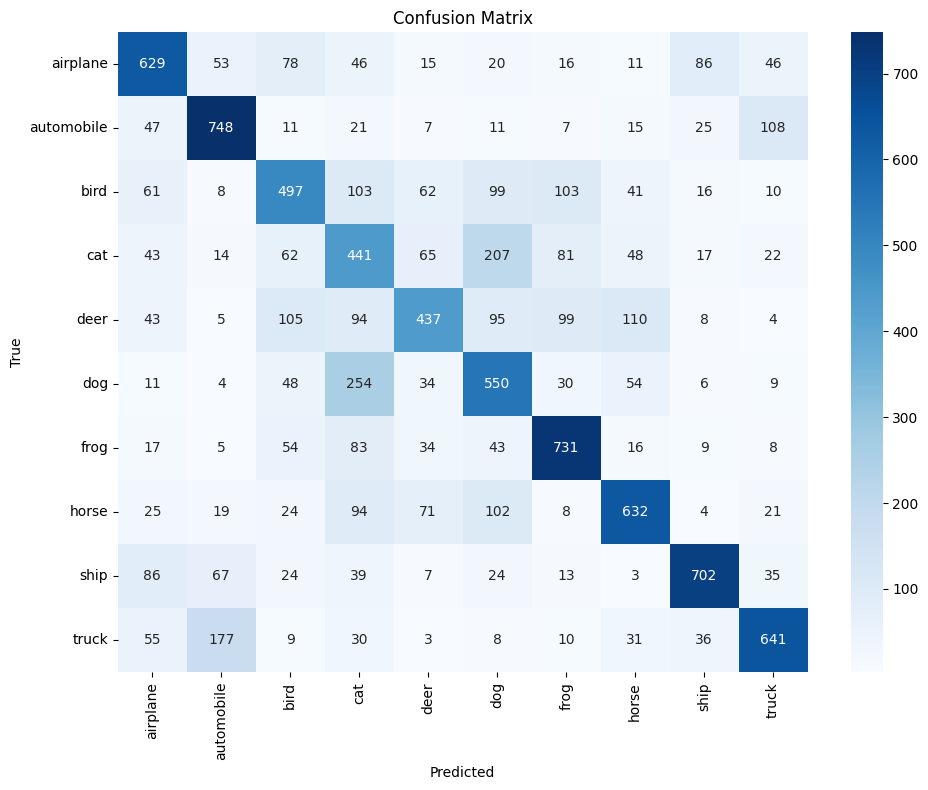

In [ ]:
evaluate(student, test_loader, device)